# Highly-multiplexed image analysis with Harpy

In this notebook we will import an unprocessed spatial proteomics dataset from the MACSima platform and perform some cell segmentation and feature calculation using Harpy.


In [41]:
import sparrow as sp
from matplotlib import pyplot as plt
import spatialdata_plot

## 1. Load the example dataset

The example dataset for this notebook will be downloaded and cached using `pooch` via `sparrow.dataset.registry`. The dataset is a small subset of a larger dataset that was generated using the MACSima platform.


In [42]:
from sparrow.datasets import macsima_example

sdata = macsima_example()
sdata

SpatialData object
└── Images
      └── 'HumanLiverH35': DataArray[cyx] (151, 1000, 1000)
with coordinate systems:
    ▸ 'global', with elements:
        HumanLiverH35 (Images)

Spatial proteomics usually differs from spatial transcriptomics in that the data is mostly highly-multiplexed images instead of just a cell staining and gene transcript locations. In this subsetted example dataset we have an image of 1000 by 1000 pixels and 151 channels from 51 staining rounds. With one DAPI stain per round, there are 100 markers of interest.


In [43]:
marker_names = sdata["HumanLiverH35"].coords["c"].values.tolist()
print(len(marker_names))
", ".join(marker_names)

151


'R0 DAPI, R1 DAPI, R1 VSIG4, R1 CD14, R2 DAPI, R2 CD163, R3 DAPI, R3 CD11c, R3 CD335, R4 DAPI, R4 CD141, R5 DAPI, R5 CD169, R5 CD49d, R6 DAPI, R6 CD279, R7 DAPI, R7 CD4, R7 CD41a, R8 DAPI, R8 CD16b, R9 DAPI, R9 CD26, R9 CD133, R10 DAPI, R10 CD36, R11 DAPI, R11 CD68, R11 CD164, R12 DAPI, R12 CD90, R13 DAPI, R13 Desmin, R13 CD123, R14 DAPI, R14 CD38, R15 DAPI, R15 CD49a, R15 CD1c, R16 DAPI, R16 CD5, R17 DAPI, R17 CD54, R17 CD206, R18 DAPI, R18 CD73, R19 DAPI, R19 CD49b, R19 CD64, R20 DAPI, R20 CD161, R21 DAPI, R21 CD41b, R21 CD55, R22 DAPI, R22 CD56, R23 DAPI, R23 CD105, R23 CD271, R24 DAPI, R24 CD107b, R25 DAPI, R25 CD133, R25 CD13, R26 DAPI, R26 CD11a, R26 CD134, R27 DAPI, R27 CD61, R27 CD177, R27 CD146, R28 DAPI, R28 CD20, R28 CD95, R29 DAPI, R29 CD24, R29 CD196, R29 CD3, R30 DAPI, R30 CD34, R30 CD230, R31 DAPI, R31 CD43, R31 CD243, R31 CD200, R32 DAPI, R32 CD268, R32 CD277, R33 DAPI, R33 CD8, R33 CD28, R33 CD22, R34 DAPI, R34 CD9, R34 CD35, R35 DAPI, R35 CD104, R35 CD235a, R35 CD276,

In [44]:
markers_of_interest = [n for n in marker_names if "DAPI" not in n]
len(markers_of_interest)

100

## 2. Plot the image

We can plot the image to see what it looks like. For this we can use the `sp.pl.plot_image` function. There is also interoperability with `spatialdata-plot` for advanced visualisation. Note that image intensities are not normalized, so combined plotting of channels may not be very informative.


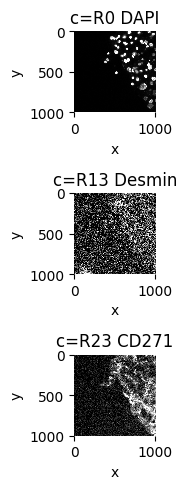

In [45]:
subset_channels = ["R0 DAPI", "R13 Desmin", "R23 CD271"]
sp.pl.plot_image(sdata, img_layer="HumanLiverH35", channel=subset_channels, figsize=(5, 5))

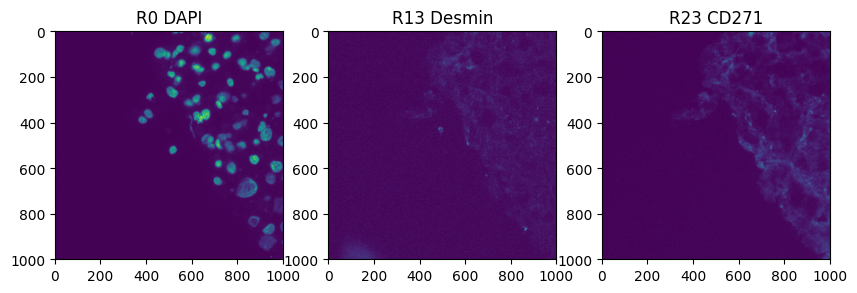

In [46]:
axes = plt.subplots(1, 3, figsize=(10, 10))[1].flatten()
for c, ax in zip(subset_channels, axes):
    sdata.pl.render_images("HumanLiverH35", channel=c).pl.show(title=c, ax=ax)

## 3. Segment using Cellpose


In [47]:
from sparrow.image.segmentation.segmentation_models._cellpose import _cellpose

sdata = sp.im.segment(
    sdata,
    img_layer="HumanLiverH35",
    chunks=1000,
    depth=200,
    model=_cellpose,  # can be any callable. GPU will be used for segmentation if it could be found by torch (torch.cuda.is_available())
    # parameters that will be passed to the callable _cellpose
    diameter=50,
    flow_threshold=0.8,
    cellprob_threshold=-4,
    output_labels_layer="segmentation_mask",
    output_shapes_layer="segmentation_mask_boundaries",
    overwrite=True,
)

2024-09-05 13:43:54,947 - sparrow.image._manager - WARNING - No dims parameter specified. Assuming order of dimension of provided array is ((c), (z), y, x)
2024-09-05 13:44:03,462 - sparrow.image._manager - INFO - Writing results to layer 'segmentation_mask'


In [48]:
sdata

SpatialData object
├── Images
│     └── 'HumanLiverH35': DataArray[cyx] (151, 1000, 1000)
├── Labels
│     └── 'segmentation_mask': DataArray[yx] (1000, 1000)
└── Shapes
      └── 'segmentation_mask_boundaries': GeoDataFrame shape: (70, 1) (2D shapes)
with coordinate systems:
    ▸ 'global', with elements:
        HumanLiverH35 (Images), segmentation_mask (Labels), segmentation_mask_boundaries (Shapes)

## 4. Visualize resulting segmentation


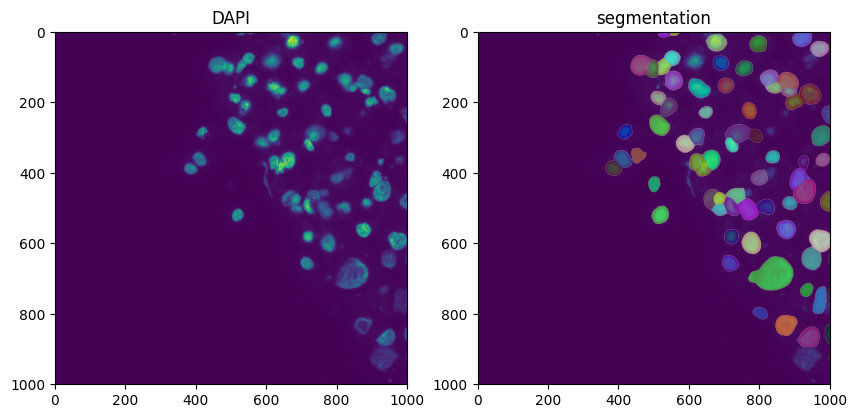

In [49]:
axes = plt.subplots(1, 2, figsize=(10, 10))[1].flatten()
sdata.pl.render_images("HumanLiverH35", channel="R0 DAPI").pl.show(ax=axes[0], title="DAPI")
sdata.pl.render_images("HumanLiverH35", channel="R0 DAPI").pl.render_labels("segmentation_mask").pl.show(
    title="segmentation", ax=axes[1]
)

## 5. Feature extraction

Now we have the location of the cells, we can try to extract features from the image to represent the expression of each cell for the marker. There are many different ways to summarize the signal to a single value. When working on spatial proteomics, it is common to use the mean intensity of the pixels in the cell instead of e.g. the count of transcripts. The mean intensity is a simple and fast way to summarize the signal, but it can be sensitive to noise. A more robust way is to use a quantile normalization first to remove intensity outliers and then calculate the mean intensity. Note that we expect the whole-slide image to be already corrected for illumination and background.

You should inspect the normalized images for each channel, as rare or abundant markers may have different distributions and need different q_min and q_max values, which `sp.im.normalize` supports.


In [50]:
sdata = sp.im.normalize(
    sdata, img_layer="HumanLiverH35", output_layer="HumanLiverH35_normalized_image", q_min=5, q_max=95
)
sdata

2024-09-05 13:44:04,406 - sparrow.image._manager - WARNING - No dims parameter specified. Assuming order of dimension of provided array is ((c), (z), y, x)
2024-09-05 13:44:09,805 - sparrow.image._manager - INFO - Writing results to layer 'HumanLiverH35_normalized_image'


SpatialData object
├── Images
│     ├── 'HumanLiverH35': DataArray[cyx] (151, 1000, 1000)
│     └── 'HumanLiverH35_normalized_image': DataArray[cyx] (151, 1000, 1000)
├── Labels
│     └── 'segmentation_mask': DataArray[yx] (1000, 1000)
└── Shapes
      └── 'segmentation_mask_boundaries': GeoDataFrame shape: (70, 1) (2D shapes)
with coordinate systems:
    ▸ 'global', with elements:
        HumanLiverH35 (Images), HumanLiverH35_normalized_image (Images), segmentation_mask (Labels), segmentation_mask_boundaries (Shapes)

Calculating the features for every cell is an intensive process and can take a long time. For this small example of 70 cells and 10 channels it can take a couple of seconds. For 51 channels, it can take 30 seconds without additional parallelization. For large whole-slide images, it is recommended to use more cores.


In [51]:
subset = 9  # to speed up the computation, change to None to process all markers
sdata = sp.tb.allocate_intensity(
    sdata,
    img_layer="HumanLiverH35_normalized_image",
    labels_layer="segmentation_mask",
    output_layer="table_intensities",
    chunks=100,
    channels=["R0 DAPI"] + markers_of_interest[:subset],
)
sdata

/Users/benjaminr/Documents/GitHub/harpy/src/sparrow/table/_allocation_intensity.py:217: ImplicitModificationWarning: Setting element `.obsm['spatial']` of view, initializing view as actual.
  adata.obsm["spatial"] = coordinates


SpatialData object
├── Images
│     ├── 'HumanLiverH35': DataArray[cyx] (151, 1000, 1000)
│     └── 'HumanLiverH35_normalized_image': DataArray[cyx] (151, 1000, 1000)
├── Labels
│     └── 'segmentation_mask': DataArray[yx] (1000, 1000)
├── Shapes
│     └── 'segmentation_mask_boundaries': GeoDataFrame shape: (70, 1) (2D shapes)
└── Tables
      └── 'table_intensities': AnnData (70, 10)
with coordinate systems:
    ▸ 'global', with elements:
        HumanLiverH35 (Images), HumanLiverH35_normalized_image (Images), segmentation_mask (Labels), segmentation_mask_boundaries (Shapes)

In [52]:
sdata["table_intensities"].to_df()

channels,R0 DAPI,R1 VSIG4,R1 CD14,R2 CD163,R3 CD11c,R3 CD335,R4 CD141,R5 CD169,R5 CD49d,R6 CD279
cells,,,,,,,,,,
28_segmentation_mask_a6296d86,8.453275,8.485674,0.081951,1.638744,0.608115,0.157106,0.316933,2.388009,0.524589,0.446725
30_segmentation_mask_a6296d86,481.477844,461.444702,3.208881,39.630463,14.820113,6.905374,17.973820,16.287153,5.468932,16.321264
31_segmentation_mask_a6296d86,273.114929,278.218292,1.598520,20.792833,8.889306,4.262804,12.501141,10.629593,3.966493,9.423994
32_segmentation_mask_a6296d86,1821.622681,1814.473999,15.792405,169.055939,73.052490,31.527687,72.733559,80.217995,41.294930,63.434566
34_segmentation_mask_a6296d86,2176.708252,1942.784180,26.035578,165.693909,64.110741,32.464184,77.349564,68.796753,56.799263,68.296951
...,...,...,...,...,...,...,...,...,...,...
117_segmentation_mask_a6296d86,1797.145508,2227.670654,19.743132,158.006531,75.400482,31.141397,74.905701,96.634911,37.125347,60.232002
119_segmentation_mask_a6296d86,236.237228,1032.827148,6.398957,228.379120,43.384563,14.236951,31.777786,257.761353,24.130495,27.231934
120_segmentation_mask_a6296d86,2369.248291,2703.972900,21.302315,232.887207,102.278770,42.206997,92.118530,183.811722,44.216293,80.043633


We also can extract geometric and morphological information based on the shape of the cells and append it as extra observations to our table. This can be useful to distinguish between different cell types. For example, we can calculate the area of the cell, the perimeter, the eccentricity, the solidity, the major and minor axis.


In [53]:
sdata = sp.tb.add_regionprop_features(sdata, labels_layer="segmentation_mask", table_layer="table_intensities")
sdata["table_intensities"]

/opt/homebrew/Caskroom/mambaforge/base/envs/harpy/lib/python3.10/site-packages/spatialdata/_core/_elements.py:116: UserWarning: Key `table_intensities` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


AnnData object with n_obs × n_vars = 70 × 10
    obs: 'cell_ID', 'fov_labels', 'area', 'eccentricity', 'major_axis_length', 'minor_axis_length', 'perimeter', 'centroid-0', 'centroid-1', 'convex_area', 'equivalent_diameter', '_major_minor_axis_ratio', '_perim_square_over_area', '_major_axis_equiv_diam_ratio', '_convex_hull_resid', '_centroid_dif'
    uns: 'spatialdata_attrs'
    obsm: 'spatial'

In [54]:
sdata["table_intensities"].obs

,cell_ID,fov_labels,area,eccentricity,major_axis_length,minor_axis_length,perimeter,centroid-0,centroid-1,convex_area,equivalent_diameter,_major_minor_axis_ratio,_perim_square_over_area,_major_axis_equiv_diam_ratio,_convex_hull_resid,_centroid_dif
cells,,,,,,,,,,,,,,,,
28_segmentation_mask_a6296d86,28,segmentation_mask,10.0,1.000000,11.489125,0.000000,8.000000,0.000000,938.500000,10.0,3.568248,NaN,6.400000,3.219822,0.000000,0.000000
30_segmentation_mask_a6296d86,30,segmentation_mask,569.0,0.849515,37.553555,19.811945,95.556349,7.950791,527.402460,583.0,26.916042,1.895501,16.047480,1.395211,0.024014,0.008750
31_segmentation_mask_a6296d86,31,segmentation_mask,338.0,0.845465,29.006027,15.490118,74.142136,6.068047,556.668639,349.0,20.744999,1.872550,16.263480,1.398218,0.031519,0.010715
32_segmentation_mask_a6296d86,32,segmentation_mask,2064.0,0.595122,57.373850,46.107664,169.882251,20.983043,918.371124,2094.0,51.263695,1.244345,13.982548,1.119191,0.014327,0.001952
34_segmentation_mask_a6296d86,34,segmentation_mask,2280.0,0.526249,58.489938,49.735775,179.823376,32.771491,675.711842,2334.0,53.879367,1.176013,14.182652,1.085572,0.023136,0.000533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117_segmentation_mask_a6296d86,117,segmentation_mask,2294.0,0.903363,83.235088,35.697612,205.296465,763.748474,968.740192,2393.0,54.044533,2.331671,18.372554,1.540120,0.041371,0.004665
119_segmentation_mask_a6296d86,119,segmentation_mask,1055.0,0.722431,44.170692,30.541510,123.639610,798.527962,799.662559,1088.0,36.650617,1.446251,14.489813,1.205183,0.030331,0.001037
120_segmentation_mask_a6296d86,120,segmentation_mask,2817.0,0.466619,63.972321,56.580862,198.752309,832.299255,872.217252,2871.0,59.889196,1.130635,14.022890,1.068178,0.018809,0.001319


<Axes: >

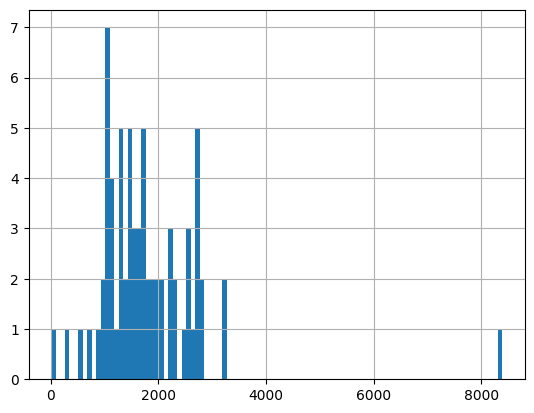

In [62]:
sdata["table_intensities"].obs["area"].hist(bins=100)

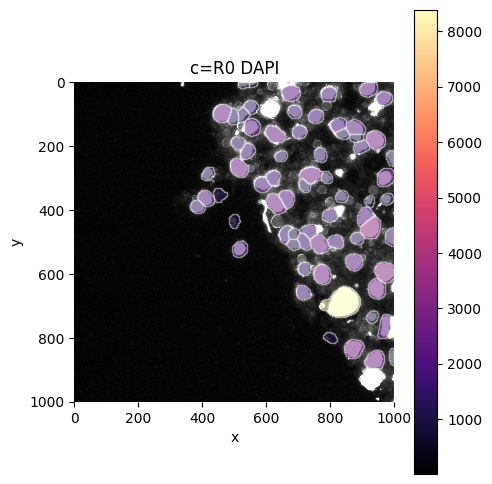

In [67]:
sp.pl.plot_shapes(
    sdata,
    img_layer="HumanLiverH35_normalized_image",
    shapes_layer="segmentation_mask_boundaries",
    table_layer="table_intensities",
    column="area",
    channel="R0 DAPI",
    figsize=(5, 5),
)

Now we can move on to cell type annotation using the extracted features.
